# Phillies Quantitative Analyst Take-Home
### Author: Ryan Williams
### Date: 05/13/2025

**Language**: Julia 1.11+

This notebook addresses Question 11 of the assessment, where we are tasked with predicting each pitcher's 2024 strikeout percentage (K%) using their prior performance data.

We use a hierarchical Bayesian model implemented via `Turing.jl` to estimate future K% while accounting for player-level effects and uncertainty.


In [1]:
# Setup Julia environment for the k_model package
using Pkg
Pkg.activate("k_model_env")
Pkg.add([
    "CSV",
    "DataFrames",
    "StatsPlots",
    "Turing",
    "Random",
    "Distributions",
    "StatsBase",
    "CategoricalArrays",
    "MCMCChains",
    "MLJ",
    "MLJLinearModels",
    "MLJBase",
    "StatisticalMeasures",
    "DecisionTree",
    "MLJDecisionTreeInterface"
])
Pkg.precompile()

  Activating project at `~/git/QuantAnalysisAssets/phillies_takehome/k_model_env`
   Resolving package versions...
  No Changes to `~/git/QuantAnalysisAssets/phillies_takehome/k_model_env/Project.toml`
  No Changes to `~/git/QuantAnalysisAssets/phillies_takehome/k_model_env/Manifest.toml`


In [12]:
# Load libraries
using CSV, DataFrames
using StatsPlots
using Turing
using Random, Distributions
using StatsBase
# using CategoricalArrays
using LinearAlgebra
using MCMCChains
using MLJ
using MLJBase
# using MLJLinearModels
using DecisionTree
using MLJDecisionTreeInterface
Random.seed!(42)

TaskLocalRNG()

## Load and inspect data
We begin by loading `k.csv`, which contains:
- Player identifiers (MLBAMID, FanGraphs ID)
- Age and season
- Total Batters Faced (TBF) and Strikeout Percentage (K%)

In [3]:
df = CSV.read("k.csv", DataFrame)
first(df, 5)

Row,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
,Int64,Int64,String31,String7,Int64,Int64,Int64,Float64
1,695243,31757,Mason Miller,OAK,25,2024,249,0.417671
2,621242,14710,Edwin Díaz,NYM,30,2024,216,0.388889
3,518585,7048,Fernando Cruz,CIN,34,2024,288,0.378472
4,623352,14212,Josh Hader,HOU,30,2024,278,0.377698
5,663574,19926,Tony Santillan,CIN,27,2024,122,0.377049


In [ ]:
describe(df)
# names(df)

## Preprocess Data
- We sort by season and player
- We compute lagged K% and TBF
- We exclude rows with missing historical data (e.g., rookies)

In [4]:
# Rename columns for clarity
rename!(df, Symbol("K%") => :K)

# Sort the DataFrame to ensure proper ordering within each player group
sort!(df, [:MLBAMID, :Season])

# Initialize new columns with missing values
df[!, :K_prev] = Vector{Union{Missing, Float64}}(missing, nrow(df))
df[!, :TBF_prev] = Vector{Union{Missing, Int64}}(missing, nrow(df))

# Fill previous season's K% and TBF for each pitcher
for g in groupby(df, :MLBAMID)
    global_indices = findall(x -> x in g.MLBAMID, df.MLBAMID)
    for i in 2:nrow(g)
        curr_idx = global_indices[i]
        prev_idx = global_indices[i - 1]

        df[!, :K_prev][curr_idx] = df[!, :K][prev_idx]
        df[!, :TBF_prev][curr_idx] = df[!, :TBF][prev_idx]
    end
end

# Drop rows that don’t have lagged values (e.g. rookies or first-year records)
df_model = dropmissing(df, [:K_prev, :TBF_prev])

# Add derived features
df_model[!, :ΔK] = df_model.K .- df_model.K_prev         # Change in K% from last season
df_model[!, :is_relief] = df_model.TBF .< 200            # Likely a reliever if under 200 TBF

1029-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

## Model Definition
We model K% as a function of prior stats, with player-level intercepts.

### Define Model Inputs

In [ ]:
unique_players = unique(df_model.MLBAMID)
player_lookup = Dict(pid => i for (i, pid) in enumerate(unique_players))
player_index = [player_lookup[pid] for pid in df_model.MLBAMID]

In [6]:
# Select feature matrix and target vector
# X = select(df_model, [:K_prev, :TBF_prev, :Age, :ΔK, :is_relief]) |> Matrix
X = select(df_model, [:K_prev, :TBF_prev, :Age, :ΔK, :is_relief])
y = df_model.K
y_vec = y

1029-element Vector{Float64}:
 0.17808219
 0.11363636
 0.12478632
 0.16357504
 0.21524664
 0.18686869
 0.32692308
 0.27659574
 0.28440367
 0.25342466
 ⋮
 0.22180451
 0.21398305
 0.17486339
 0.20353982
 0.24342105
 0.17445483
 0.2
 0.41767068
 0.19811321

### Fit the Model

In [7]:
# # Fit Ridge Regression with MLJ
# model = RidgeRegressor(lambda=0.1)
# mach = machine(model, X, y)
# fit!(mach)

In [13]:
# Fit Random Forest Regressor with MLJ
RandomForest = @load RandomForestRegressor pkg=DecisionTree

model_instance = RandomForest(n_trees=100)
mach = machine(model_instance, X, y)
MLJBase.fit!(mach)

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/ryanwilliams/.julia/packages/MLJModels/nxeCf/src/loading.jl:159
┌ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).
└ @ MLJBase /Users/ryanwilliams/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


trained Machine; caches model-specific representations of data
  model: RandomForestRegressor(max_depth = -1, …)
  args: 
    1:	Source @901 ⏎ Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{Count}}}
    2:	Source @941 ⏎ AbstractVector{ScientificTypesBase.Continuous}


### Make Predictions

In [14]:
y_pred = MLJ.predict(mach, X) |> MLJ.unwrap

1029-element Vector{Float64}:
 0.18116389170000005
 0.1338821377
 0.13307088336666667
 0.17406201956666664
 0.21146177489999998
 0.1904113057666667
 0.3210197852333333
 0.27868111295
 0.2842724276166667
 0.2501212379466667
 ⋮
 0.21834271388333337
 0.21327361854
 0.17621996594500003
 0.2013836627883334
 0.24281857229333328
 0.1817210966
 0.20498630575
 0.3812428746
 0.20428316234999996

### Performance Evaluation

In [15]:
r2 = rsq(y_pred, y_vec)
rmse = sqrt(mean((y_pred .- y_vec).^2))

println("R² Score: ", round(r2, digits=4))
println("RMSE: ", round(rmse, digits=4))

R² Score: 0.9827
RMSE: 0.0073


In [ ]:
# Store predictions in DataFrame
df_model.K_pred = y_pred

### Result Visualizations

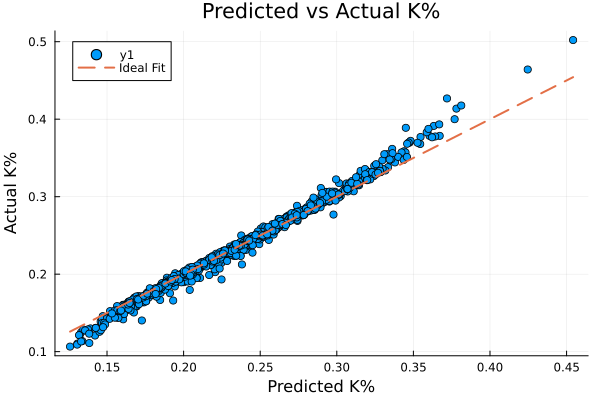

In [16]:
scatter(y_pred, y_vec, xlabel="Predicted K%", ylabel="Actual K%", title="Predicted vs Actual K%")
plot!(identity, label="Ideal Fit", linewidth=2, linestyle=:dash)

## Predict K% for 2024 season (out-of-sample test)

In [17]:
# Split into training (before 2024) and test (2024 season)
df_train = filter(row -> row.Season < 2024, df_model)
df_test = filter(row -> row.Season == 2024, df_model)

Row,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K,K_prev,TBF_prev,ΔK,is_relief
,Int64,Int64,String31,String7,Int64,Int64,Int64,Float64,Float64,Int64,Float64,Bool
1,434378,8700,Justin Verlander,HOU,41,2024,396,0.186869,0.215247,669,-0.0283779,false
2,445276,3096,Kenley Jansen,BOS,36,2024,218,0.284404,0.276596,188,0.00780793,false
3,445926,5448,Jesse Chavez,ATL,40,2024,264,0.208333,0.270833,144,-0.0625,false
4,450203,4676,Charlie Morton,ATL,40,2024,701,0.238231,0.255587,716,-0.0173555,false
5,453286,3137,Max Scherzer,TEX,39,2024,177,0.225989,0.280193,621,-0.0542045,true
6,455119,11847,Chris Martin,BOS,38,2024,180,0.277778,0.231156,199,0.046622,true
7,458677,4301,Justin Wilson,CIN,36,2024,209,0.244019,0.194631,149,0.0493883,false
8,458681,2520,Lance Lynn,STL,37,2024,511,0.213307,0.236386,808,-0.0230789,false
9,471911,6632,Carlos Carrasco,CLE,37,2024,447,0.199105,0.158273,417,0.0408318,false


In [18]:
# Feature matrix and target vector for train/test
X_train = select(df_train, [:K_prev, :TBF_prev, :Age, :ΔK, :is_relief])
y_train = df_train.K

X_test = select(df_test, [:K_prev, :TBF_prev, :Age, :ΔK, :is_relief])
y_test = df_test.K

366-element Vector{Float64}:
 0.18686869
 0.28440367
 0.20833333
 0.2382311
 0.2259887
 0.27777778
 0.24401914
 0.21330724
 0.19910515
 0.20866142
 ⋮
 0.24468085
 0.22180451
 0.21398305
 0.20353982
 0.24342105
 0.17445483
 0.2
 0.41767068
 0.19811321

In [19]:
# Sanity check: Ensure no overlap in player-season rows (by MLBAMID and Season)
@assert isempty(intersect(
    zip(df_train.MLBAMID, df_train.Season),
    zip(df_test.MLBAMID, df_test.Season)
)) "Train/test data leakage detected!"

In [ ]:
# Fit model on training data
model_2024 = model(n_trees=100)
mach_2024 = machine(model_2024, X_train, y_train)
MLJ.fit!(mach_2024)

UndefVarError: UndefVarError: `fit!` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.
Hint: a global variable of this name also exists in StatsBase.
Hint: a global variable of this name also exists in MLJBase.
Hint: a global variable of this name also exists in MLJ.
Hint: a global variable of this name may be made accessible by importing ScikitLearnBase in the current active module Main
Hint: a global variable of this name also exists in DecisionTree.

In [ ]:
# Predict and evaluate on 2024 holdout set
y_pred_2024 = MLJ.predict(mach_2024, X_test) |> MLJ.unwrap

r2_2024 = 1 - sum((y_test .- y_pred_2024) .^ 2) / sum((y_test .- mean(y_test)) .^ 2)
rmse_2024 = sqrt(mean((y_test .- y_pred_2024) .^ 2))

println("\n2024 Holdout Performance:")
println("R² Score (2024): ", round(r2_2024, digits=4))
println("RMSE (2024): ", round(rmse_2024, digits=4))